Anomaly Detection on Romanian first tour of presidentials elections

In this project, using the data from roaep ( Agentia Electorala Permanenta) that was made public through a csv (pv_part_cntry_prsd), I seek to find out where candidates have a higher/lower score than their average score.

As the elections are through 49 elections comittes(precinct_county_name) and results are very diverse. We will target the data group by a single city(uat_name) and election comitte.

Also we will want to see the differences from votting to each election committe as of overall performance through the country


The Anomalies in the dataset are both local and cluster

Local : Overperforming/underpermforming in a election precinct comparing to the town where the precinct is located, but the result would be normal comparred to the candidate's country overall. This example can arise certain mistakes ( real mistake happened, but fixed in time: Kelemen Hunor received 389 votes in some precinct in Bucharest where his overall performance would have been 1-3 votes)

Cluster : They do not fit on a group of data . Most obvious example also Kelemen Hunor by having < 5% votes in all the country but in hungarian majority counties, would have more than > 50%. 





In [509]:
#neccessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from pyod.models.loda import LODA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


Exploring the dataset

- look into it, clear where is needed and normalize the values as to compare the overall performance rather than total number of votes as a candidate can have 100 votes in a precinct with 50 % total votes, but in other with the same number of votes would be at 10 %

- plot overall distribution for all candidates to get some idea about the anomaly we would detect

In [510]:
dataset = pd.read_csv('pv_part_cntry_prsd.csv')
# cleaning the data of unnecessary columns
unnecsary_colums = ["uat_siruta","report_version","report_stage_code","report_type_scope_code","report_type_category_code","report_type_scope_code","report_type_category_code","report_type_code","created_at","b1","b2","b3","d","e","f"]
dataset = dataset.drop(unnecsary_colums, axis=1)
# rename some columns to be more intuitive
dataset = dataset.rename(columns={"a":"total expected votants" ,"b": "total votants", "c":"total valid votes"})
dataset.head()

,precinct_county_nce,precinct_county_name,precinct_name,precinct_nr,uat_name,total expected votants,total votants,total valid votes,ELENA-VALERICA LASCONI-voturi,GEORGE-NICOLAE SIMION-voturi,...,HUNOR KELEMEN-voturi,MIRCEA-DAN GEOANĂ-voturi,ANA BIRCHALL-voturi,ALEXANDRA-BEATRICE BERTALAN-PĂCURARU-voturi,SEBASTIAN-CONSTANTIN POPESCU-voturi,LUDOVIC ORBAN-voturi,CĂLIN GEORGESCU-voturi,CRISTIAN DIACONESCU-voturi,CRISTIAN-VASILE TERHEȘ-voturi,SILVIU PREDOIU-voturi
0,1,ALBA,CENTRUL DE ZI PENTRU PERSOANE VÂRSTNICE,1,MUNICIPIUL ALBA IULIA,1755,971,953,242,87,...,9,103,7,2,2,4,158,59,24,0
1,1,ALBA,ŞCOALA GIMNAZIALĂ „VASILE GOLDIŞ”,2,MUNICIPIUL ALBA IULIA,985,521,511,110,69,...,9,50,2,0,4,1,74,35,8,0
2,1,ALBA,ŞCOALA GIMNAZIALĂ „VASILE GOLDIŞ”,3,MUNICIPIUL ALBA IULIA,1290,693,683,157,61,...,18,70,5,2,2,0,127,40,12,1
3,1,ALBA,ŞCOALA GIMNAZIALĂ „AVRAM IANCU”,4,MUNICIPIUL ALBA IULIA,1247,709,700,153,78,...,10,88,5,1,0,0,81,46,7,2
4,1,ALBA,ŞCOALA GIMNAZIALĂ „AVRAM IANCU”,5,MUNICIPIUL ALBA IULIA,962,544,539,115,75,...,10,58,7,0,2,4,90,22,9,0


In [511]:

#normalize the data in precents for every candidate and for the total valid votes
candidate_columns = ["ELENA-VALERICA LASCONI-voturi","GEORGE-NICOLAE SIMION-voturi","ION-MARCEL CIOLACU-voturi","NICOLAE-IONEL CIUCĂ-voturi","HUNOR KELEMEN-voturi","MIRCEA-DAN GEOANĂ-voturi","ANA BIRCHALL-voturi","ALEXANDRA-BEATRICE BERTALAN-PĂCURARU-voturi","SEBASTIAN-CONSTANTIN POPESCU-voturi","LUDOVIC ORBAN-voturi","CĂLIN GEORGESCU-voturi","CRISTIAN DIACONESCU-voturi","CRISTIAN-VASILE TERHEȘ-voturi","SILVIU PREDOIU-voturi"]
normalized_dataset = dataset.copy()
def normalize_function(df):
    for i in candidate_columns:
        df[i] = df[i]/df["total valid votes"]
    

normalize_function(normalized_dataset)


In [512]:
#group the data by counties
voturi_columns = ["total expected votants","total votants","total valid votes"] + candidate_columns
dataset_group_by_county = dataset.groupby('precinct_county_name')[voturi_columns].sum().reset_index()

dataset_group_by_county.head()

normalize_dataset_group_by_county = dataset_group_by_county.copy()
normalize_function(normalize_dataset_group_by_county)

normalize_dataset_group_by_county.head()



,precinct_county_name,total expected votants,total votants,total valid votes,ELENA-VALERICA LASCONI-voturi,GEORGE-NICOLAE SIMION-voturi,ION-MARCEL CIOLACU-voturi,NICOLAE-IONEL CIUCĂ-voturi,HUNOR KELEMEN-voturi,MIRCEA-DAN GEOANĂ-voturi,ANA BIRCHALL-voturi,ALEXANDRA-BEATRICE BERTALAN-PĂCURARU-voturi,SEBASTIAN-CONSTANTIN POPESCU-voturi,LUDOVIC ORBAN-voturi,CĂLIN GEORGESCU-voturi,CRISTIAN DIACONESCU-voturi,CRISTIAN-VASILE TERHEȘ-voturi,SILVIU PREDOIU-voturi
0,ALBA,302724,156780,153221,0.141423,0.159724,0.157779,0.183989,0.028234,0.053609,0.004118,0.002330,0.002010,0.002376,0.218860,0.029226,0.015109,0.001214
1,ARAD,379796,175475,171476,0.145886,0.172450,0.148837,0.132386,0.049715,0.051879,0.004380,0.001236,0.001790,0.002024,0.232919,0.028599,0.026785,0.001114
2,ARGEŞ,509751,273618,267604,0.180315,0.145484,0.247489,0.075873,0.001536,0.055967,0.003393,0.000796,0.001241,0.001547,0.248479,0.030597,0.006543,0.000740
3,BACĂU,588351,244755,236564,0.165393,0.157995,0.248580,0.064097,0.009312,0.066604,0.004916,0.002904,0.002114,0.002807,0.233573,0.033099,0.007085,0.001522
4,BIHOR,497051,248203,242587,0.124763,0.116696,0.168026,0.151471,0.181209,0.041540,0.003017,0.000993,0.001620,0.001983,0.168142,0.019074,0.020793,0.000672


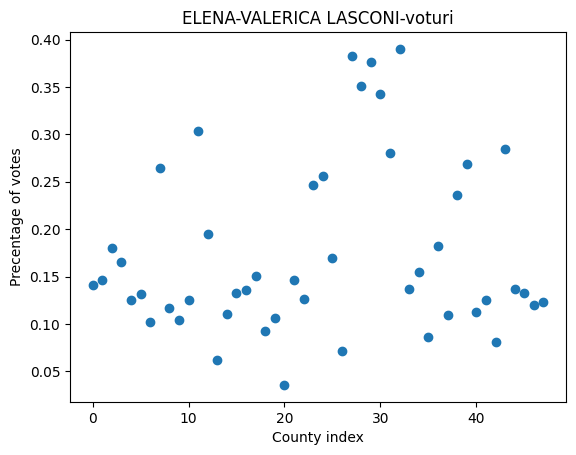

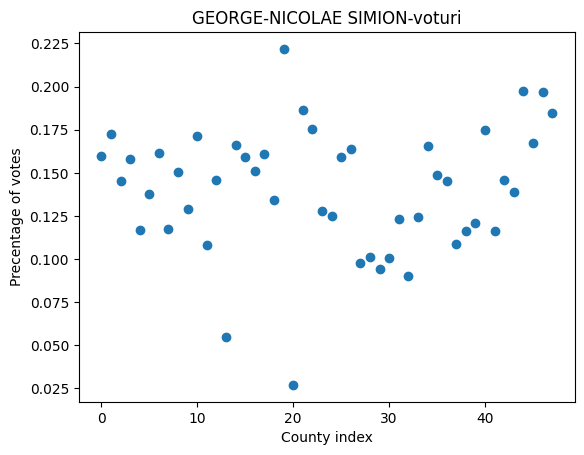

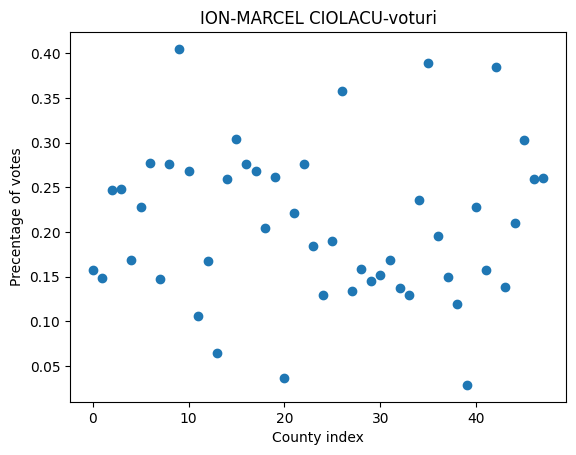

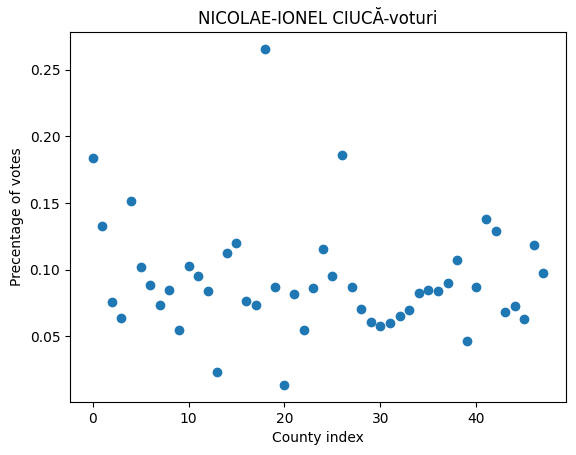

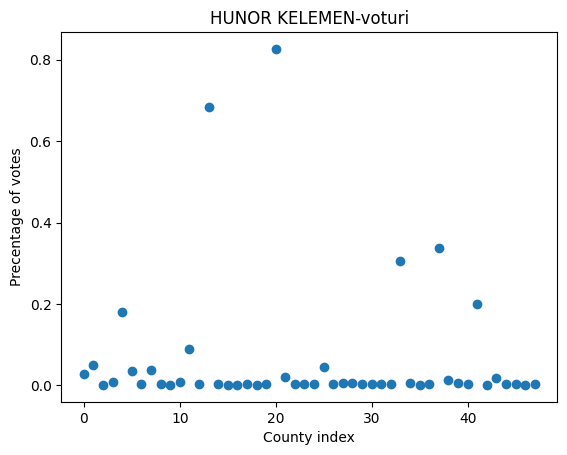

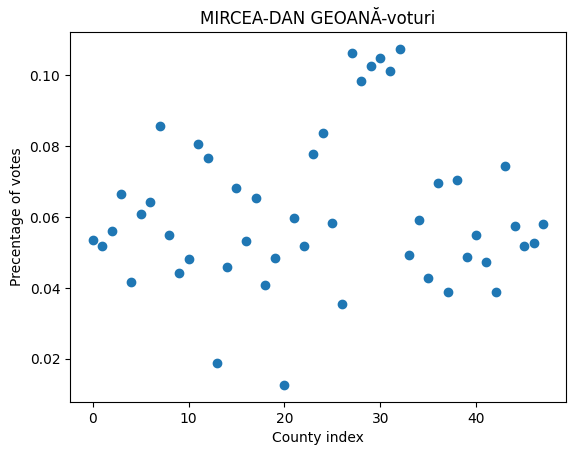

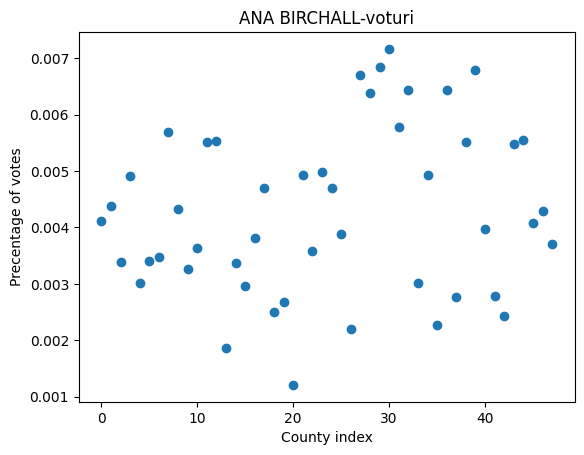

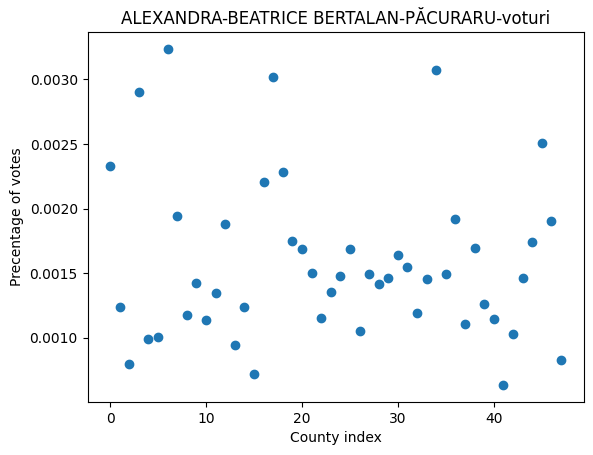

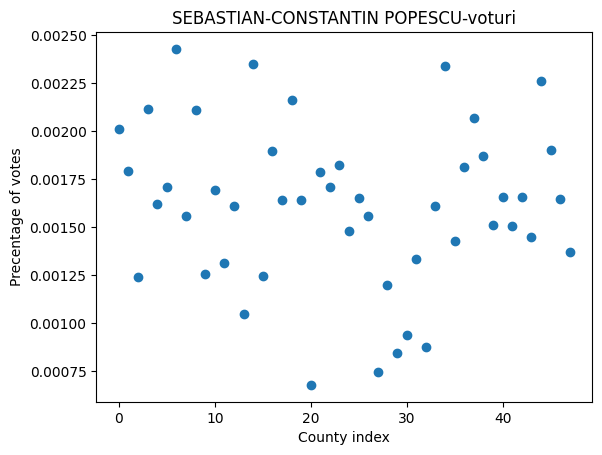

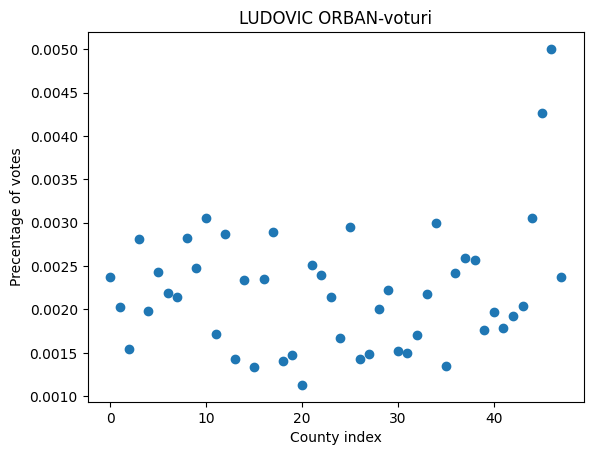

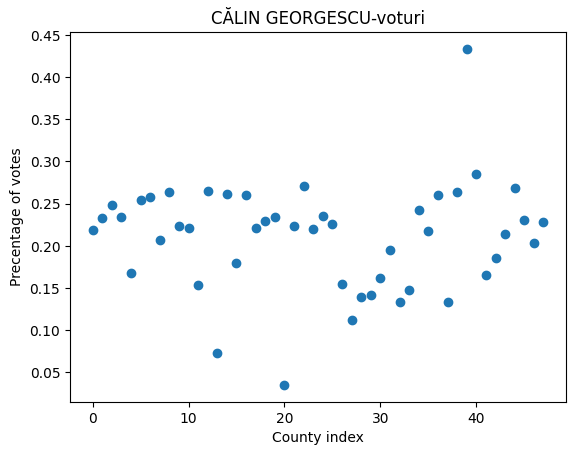

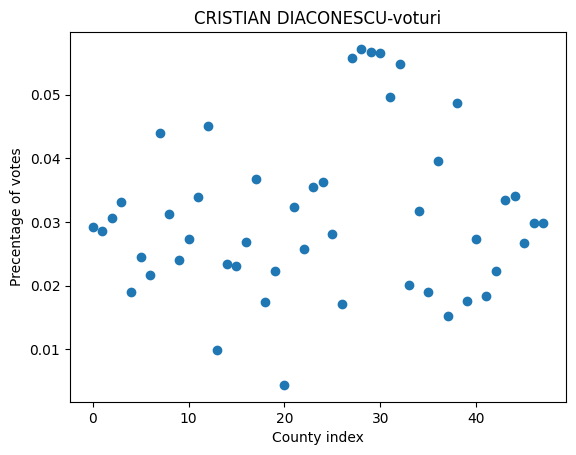

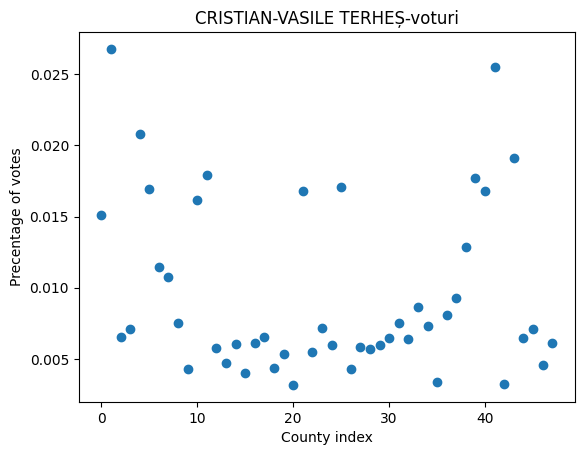

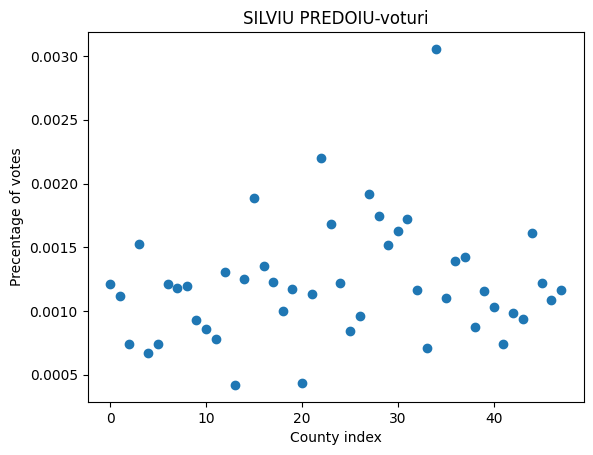

In [ ]:
# scatter the distribution of every candidates votes through the every county 

def scatter_distribution(df):
    for i in candidate_columns:
        plt.scatter(df["precinct_county_name"].index,df[i])
        plt.title(i)
        plt.xlabel("County index")
        plt.ylabel("Precentage of votes")
        plt.show()

scatter_distribution(normalize_dataset_group_by_county)

Anomaly Detection Method 

KNN
- identifies anomalies by comparing the distance of a point to its nearest neighbors. Anomalies are points that are significantly far from their neighbors compared to the majority of the data.
- Works well in detecting local anomalies in structured datasets.
- Sensitive to scaling and computationally expensive for large datasets.

LODA 
- especially well-suited for data with different features. 
- It operates by applying random projections of the data onto lower-dimensional spaces.
- Anomalies are detected based on their behavior in these projected spaces, assuming that the majority of data points are grouped together in these lower dimensions, while anomalies stand out as sparse or isolated.

Implementation: 

- for this implementation i will use the pyod already implemented methods for KNN and LODA and i will provide the outlier_fraction ( percent of how many outliers would be considered 0.1 about 10%)

The implementation for both of them is the same and it would be just a difference of calling the method

First step : preprocess the data, we transform the data to have zero mean and unit variance(-1 1) because these methods are sensitive to the scale of the features

Second step : fitting the data into our model then taking the anomaly_score and the label if it is inliner or outliner

Third step : plotting the data based on the anomaly_score ( not the actual percentil of it).

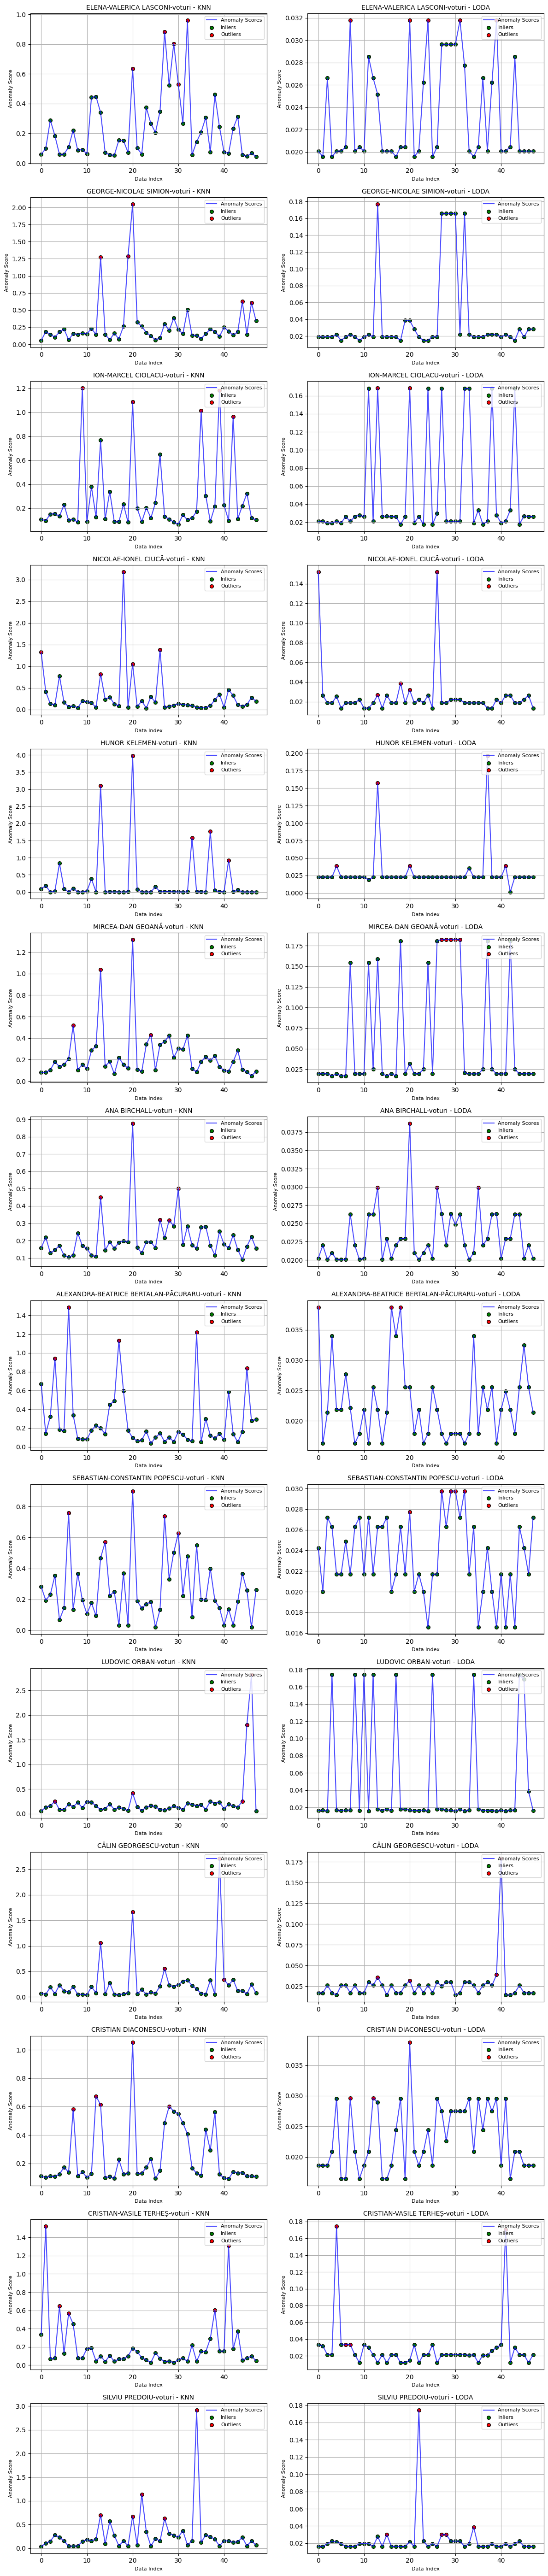

In [522]:
def plot_anomalies_for_candidates(df, candidate_columns, outlier_fraction=0.1):
    
    classifiers = {
        'KNN': KNN(contamination=outlier_fraction),
        'LODA': LODA(contamination=outlier_fraction)
    }

    num_candidates = len(candidate_columns)
    num_classifiers = len(classifiers)

    plt.figure(figsize=(num_classifiers * 6, num_candidates * 4))

    for i, candidate in enumerate(candidate_columns):

        vote_data = df[candidate].values
        scaler = StandardScaler()
        vote_data_scaled = scaler.fit_transform(vote_data.reshape(-1, 1))

        for j, (clf_name, clf) in enumerate(classifiers.items()):
            clf.fit(vote_data_scaled)

            # Get anomaly scores and predictions
            scores_pred = clf.decision_scores_ 
            y_pred = clf.labels_  # 0 for inliers, 1 for outliers

            # Create subplot
            ax = plt.subplot(num_candidates, num_classifiers, i * num_classifiers + j + 1)

            # Plot anomaly scores
            ax.plot(
                np.arange(len(vote_data_scaled)),
                scores_pred,
                label="Anomaly Scores",
                color='blue',
                alpha=0.7
            )

            # Highlight outliers and inliers
            ax.scatter(
                np.arange(len(vote_data_scaled))[y_pred == 0],
                scores_pred[y_pred == 0],
                c='green',
                s=30,
                edgecolor='k',
                label='Inliers'
            )
            ax.scatter(
                np.arange(len(vote_data_scaled))[y_pred == 1],
                scores_pred[y_pred == 1],
                c='red',
                s=30,
                edgecolor='k',
                label='Outliers'
            )

            ax.set_title(f'{candidate} - {clf_name}', fontsize=10)
            ax.set_xlabel('Data Index', fontsize=8)
            ax.set_ylabel('Anomaly Score', fontsize=8)
            ax.grid(True)
            ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_anomalies_for_candidates(normalize_dataset_group_by_county, candidate_columns, 0.1)

Evaluating the performance

- as we see through this graph we can already see some differences between the output from the 2 models
- so we are going to use some metrics to evaluate our difference :
    - dunn-index :
        - evaluate the compactness and separation of clusters in clustering algorithms. It measures how well-separated and distinct the clusters are
        - higher dunn index indicates that clusters are more separated and more compact and a lower one poor separation and poor compactness
        - is defined by ( min(distance between centroids of different clusters)) / max( distance between 2 points of same clusters)
    
    - cohesion-score :
        - used to measure the compactness or tightness of clusters. It evaluates how close the points within each cluster are to the cluster's centroid. 
        - cohesion score : 1/k sum(1/Nk sum( distance(xi,Ck))) xi some point in the cluster Ck where k is number of clusters

    - silhouette-score :
        - evaluate the quality of clusters in a dataset. It measures how similar each point is to its own cluster (cohesion) compared to other clusters (separation). 
        
        

In [521]:
def dunn_index(X, labels):
    clusters = np.unique(labels)
    cluster_centers = np.array([X[labels == cluster].mean(axis=0) for cluster in clusters])
    distances_between_clusters = cdist(cluster_centers, cluster_centers, metric='euclidean')
    min_dist = np.min(distances_between_clusters[np.nonzero(distances_between_clusters)])
    max_intra_dist = np.max([np.max(cdist(X[labels == cluster], [cluster_centers[i]], metric='euclidean')) for i, cluster in enumerate(clusters)])
    return min_dist / max_intra_dist

def cohesion_score(X, labels):
    clusters = np.unique(labels)
    cohesion = np.mean([np.mean(cdist(X[labels == cluster], [X[labels == cluster].mean(axis=0)], metric='euclidean')) for cluster in clusters])
    return cohesion

def evaluate_models(df, candidate_columns, outlier_fraction=0.1,bool_one_county = False):
    # Define classifiers
    classifiers = {
        'LODA': LODA(contamination=outlier_fraction),
        'KNN': KNN(contamination=outlier_fraction)
    }
    
    # Prepare results for metrics
    results = {}
    
    for clf_name, clf in classifiers.items():
        results[clf_name] = {}
        
        for candidate in candidate_columns:
            vote_data = df[candidate].values.reshape(-1, 1)  # Reshape data for model input
            
            # Standardize the data
            scaler = StandardScaler()
            vote_data_scaled = scaler.fit_transform(vote_data)
            
            # Fit the classifier
            clf.fit(vote_data_scaled)
            
            # Get predictions and anomaly scores
            y_pred = clf.predict(vote_data_scaled)
            anomaly_scores = clf.decision_scores_  # raw anomaly scores
            
            # Store results
            results[clf_name][candidate] = {
                'y_pred': y_pred,
                'anomaly_scores': anomaly_scores
            }
            
            if len(np.unique(y_pred)) > 1:  # Silhouette score requires at least 2 clusters
                silhouette_avg = silhouette_score(vote_data_scaled, y_pred)
                results[clf_name][candidate]['silhouette_score'] = silhouette_avg
            else:
                results[clf_name][candidate]['silhouette_score'] = None

            # Calculate Dunn Index
            dunn_idx = dunn_index(vote_data_scaled, y_pred)
            results[clf_name][candidate]['dunn_index'] = dunn_idx

            # Calculate Cohesion Score
            cohesion = cohesion_score(vote_data_scaled, y_pred)
            results[clf_name][candidate]['cohesion_score'] = cohesion
    
    # Print evaluation results
    for clf_name in classifiers.keys():
        print(f"\n{clf_name} Performance:")
        for candidate in candidate_columns:
            print(f"  Candidate: {candidate}")
            print(f"    - Silhouette Score: {results[clf_name][candidate]['silhouette_score']}")
            print(f"    - Dunn Index: {results[clf_name][candidate]['dunn_index']}")
            print(f"    - Cohesion Score: {results[clf_name][candidate]['cohesion_score']}")
            print(f"    - Predicted Outliers: {np.sum(results[clf_name][candidate]['y_pred'] == 1)}")
            print(f"    - Average values of distribution percentage: {df[candidate].mean()}")
            # print anomaly precinct_counties_name and candidate
            if(bool_one_county == False):
                print(f"    - Outlier Precinct Counties: {df[results[clf_name][candidate]['y_pred'] == 1][['precinct_county_name',candidate]].values}")
            if(bool_one_county == True):
                # print precinct_name and precinct_nr columns
                print(f"    - Outlier Precinct Counties: {df[results[clf_name][candidate]['y_pred'] == 1][['precinct_name','precinct_nr',candidate]].values}")
                

            print("\n")
    

evaluate_models(normalize_dataset_group_by_county,['ELENA-VALERICA LASCONI-voturi'], outlier_fraction=0.2)




LODA Performance:
  Candidate: ELENA-VALERICA LASCONI-voturi
    - Silhouette Score: 0.518198488686043
    - Dunn Index: 0.5451033330571597
    - Cohesion Score: 0.6405018104101627
    - Predicted Outliers: 9
    - Average values of distribution percentage: 0.17402159069118486
    - Outlier Precinct Counties: [['BRAŞOV' 0.26411538331320744]
 ['HARGHITA' 0.035639341755375635]
 ['ILFOV' 0.2559320549864285]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 1' 0.3831706643714374]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 2' 0.35085019820571667]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 3' 0.3760388355615603]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 4' 0.3424408014571949]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 5' 0.27988269896493984]
 ['STRĂINĂTATE' 0.2682474113102743]]



KNN Performance:
  Candidate: ELENA-VALERICA LASCONI-voturi
    - Silhouette Score: 0.5865840762437452
    - Dunn Index: 0.5839543235666125
    - Cohesion Score: 0.7023166201915205
    - Predicted Outliers: 7
    - Average values of distribution percentage: 0.174021590

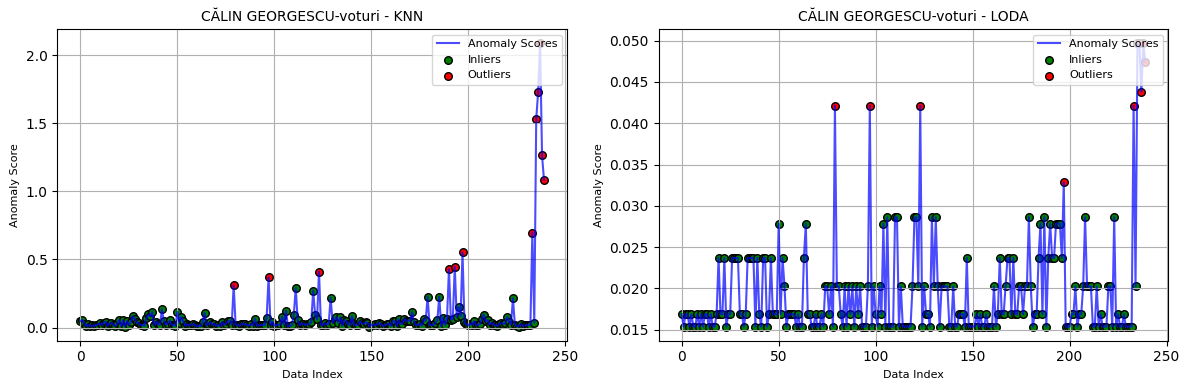


LODA Performance:
  Candidate: ELENA-VALERICA LASCONI-voturi
    - Silhouette Score: 0.4922955829032004
    - Dunn Index: 1.32564737831147
    - Cohesion Score: 0.6683657647751174
    - Predicted Outliers: 4
    - Average values of distribution percentage: 0.21921489340343556
    - Outlier Precinct Counties: [['COLEGIUL TEHNIC „APULUM”' 12 0.17194570135746606]
 ['GRĂDINIŢA CU PROGRAM NORMAL NR. 10' 34 0.16211878009630817]
 ['CĂMINUL CULTURAL OARDA DE JOS' 49 0.16740088105726872]
 ['ŞCOALA PRIMARĂ PÂCLIŞA' 51 0.10817941952506596]]


  Candidate: GEORGE-NICOLAE SIMION-voturi
    - Silhouette Score: 0.296438787303371
    - Dunn Index: 0.4791421191114878
    - Cohesion Score: 0.46840928836177986
    - Predicted Outliers: 6
    - Average values of distribution percentage: 0.13539520361199184
    - Outlier Precinct Counties: [['COLEGIUL NAŢIONAL „HOREA CLOŞCA ŞI CRIŞAN”' 11 0.15835140997830802]
 ['GRĂDINIŢA CU PROGRAM PRELUNGIT NR. 9' 15 0.16272189349112426]
 ['SEMINARUL TEOLOGIC ORTODOX „S

In [529]:
def take_data_from_one_county(df, county_name):
    return df[df["precinct_county_name"] == county_name]

def take_data_from_one_city(df, city_name):
    return df[df["uat_name"] == city_name]

df_one_county = take_data_from_one_county(dataset, "MUNICIPIUL BUCUREŞTI - SECTOR 6") 
normalized_one_county = df_one_county.copy()
normalize_function(normalized_one_county)

plot_anomalies_for_candidates(normalized_one_county, candidate_columns[10:11], 0.05)
# evaluate_models(normalized_one_county, candidate_columns[10:11], outlier_fraction=0.05, bool_one_county = True)

df_one_city = take_data_from_one_city(dataset, "MUNICIPIUL ALBA IULIA")
normalied_one_city = df_one_city.copy()
normalize_function(normalied_one_city)
# plot_anomalies_for_candidates(normalied_one_city, candidate_columns, 0.05)
evaluate_models(normalied_one_city, candidate_columns, outlier_fraction=0.15, bool_one_county = True)



In [517]:
# normalize_dataset_group_by_county = normalize_dataset_group_by_county.drop(normalize_dataset_group_by_county[normalize_dataset_group_by_county["precinct_county_name"] == "COVASNA"].index)
# normalize_dataset_group_by_county = normalize_dataset_group_by_county.drop(normalize_dataset_group_by_county[normalize_dataset_group_by_county["precinct_county_name"] == "HARGHITA"].index)
# normalize_dataset_group_by_county = normalize_dataset_group_by_county.drop(normalize_dataset_group_by_county[normalize_dataset_group_by_county["precinct_county_name"] == "MURES"].index)
# normalize_dataset_group_by_county = normalize_dataset_group_by_county.drop(normalize_dataset_group_by_county[normalize_dataset_group_by_county["precinct_county_name"] == "STRĂINĂTATE"].index)
evaluate_models(normalize_dataset_group_by_county,['ELENA-VALERICA LASCONI-voturi'], outlier_fraction=0.3)



LODA Performance:
  Candidate: ELENA-VALERICA LASCONI-voturi
    - Silhouette Score: 0.5675822921046993
    - Dunn Index: 0.6056159726031912
    - Cohesion Score: 0.535236999951332
    - Predicted Outliers: 15
    - Average values of distribution percentage: 0.17402159069118486
    - Outlier Precinct Counties: [['ARGEŞ' 0.18031494297544132]
 ['BRAŞOV' 0.26411538331320744]
 ['CLUJ' 0.3038985749679526]
 ['CONSTANŢA' 0.19448278648235556]
 ['HARGHITA' 0.035639341755375635]
 ['ILFOV' 0.2559320549864285]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 1' 0.3831706643714374]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 2' 0.35085019820571667]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 3' 0.3760388355615603]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 4' 0.3424408014571949]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 5' 0.27988269896493984]
 ['MUNICIPIUL BUCUREŞTI - SECTOR 6' 0.3901280395954379]
 ['PRAHOVA' 0.1819620153027321]
 ['STRĂINĂTATE' 0.2682474113102743]
 ['TIMIŞ' 0.2840233238039428]]



KNN Performance:
  Candidate: ELENA-VALERICA LASCONI-vo

 First set of conclusions Conclusions :

As we see through this analysis, the expected top 3 would have been Calin Georgescu, Marcel Ciolacu ( by thin margin from Calin Georgescu) and Elena Lasconi if we were to take the mean distribution of percentile vote throughout the country.

But as the analysis of anomaly detection has gathered we can see, that Marcel Ciolacu underperformed in Strainatate or in big cities, where Lasconi overperformed especially in big cities that secured her the second place, even though she performed rather poorly in the rest of the country

As compared to Calin Georgescu, he didnt have that many anomalies risen as his other contracandidates, as he performed more consistenly throught the country ( making exception of Strainatate where he overperformed consistenly). 

If we were to take out Diaspora, Ciolacu would have surpass Calin Georgescu in overall distribution. 

Second conclusions arising the difference between anomaly detections methods on the city of Alba Iulia

1. Silhouette Score
    - LODA: Generally higher, reflecting better-defined clusters across most candidates.
        - Example: HUNOR KELEMEN has the highest (0.8577) using LODA.
    - KNN: Lower in comparison, showing less distinct clustering.
        - Example: HUNOR KELEMEN's silhouette is 0.8046 using KNN.
2. Dunn Index
    - LODA: Performs better for distinct cluster separation in most cases.
        - Example: HUNOR KELEMEN with 1.3831 (LODA) versus 0.7541 (KNN).
    - KNN: Lower values indicate weaker separation of clusters.
3. Cohesion Score
    - LODA: Better cohesion (lower values) for candidates with strong cluster centrality.
        - Example: HUNOR KELEMEN has a cohesion score of 1.5507 (LODA), while KNN scores 1.4121.
    - KNN: Often has higher cohesion scores, indicating weaker consistency.
4. Predicted Outliers
    - LODA: Identifies more anomalies in certain candidates due to its grid-based approach.
        - Example: ANA BIRCHALL shows 8 outliers (LODA), while KNN identifies 5.
    - KNN: Generally identifies fewer anomalies, potentially underestimating.
5. Average Distribution Percentage  
    - LODA: Better reflects subtle outlier distributions in specific candidates.
        - Example: CĂLIN GEORGESCU has a 0.2049 distribution (LODA), higher than most using KNN.
    - KNN: Provides comparable percentages but slightly less sensitive for certain candidat

Key Findings

Best for Cluster Separation:

- LODA demonstrates higher Silhouette Scores and Dunn Index values, making it suitable for datasets with distinct clusters.
    
- Best for Cohesion: KNN shows lower cohesion for some candidates, though LODA often identifies anomalies better.

- Outlier Detection: LODA detects more outliers, which may be beneficial for anomaly-rich datasets. KNN might underdetect but offers a conservative approach.

- Distribution Consistency: LODA provides better insights into subtle variations in distribution, especially for candidates with outlier-heavy precinct

Bibliography :
 - https://prezenta.roaep.ro/prezidentiale24112024/pv/romania/results
 - https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
 - https://medium.com/dataman-in-ai/anomaly-detection-with-pyod-b523fc47db9
 - https://www.youtube.com/watch?v=QPjG_313GOw&t=547s&pp=ygUWYW5vbWFseSBkZXRlY3Rpb24gcHlvZA%3D%3D
 - https://www.youtube.com/watch?v=pdF4V23Hj5Y&pp=ygUWYW5vbWFseSBkZXRlY3Rpb24gcHlvZA%3D%3D
 - https://pyod.readthedocs.io/en/latest/